In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
os.chdir('/content/drive/MyDrive/0_Hybrid_Model/pyimagesearch')

In [3]:
from timeseires.CNN1D.GoogLeNet1D import PC
from timeseires.utils.to_split import to_split
from timeseires.callbacks.EpochCheckpoint import EpochCheckpoint
from tensorflow.keras.callbacks import ModelCheckpoint
from timeseires.callbacks.TrainingMonitor import TrainingMonitor
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv1D,TimeDistributed
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten,MaxPooling1D,Concatenate,AveragePooling1D, GlobalMaxPooling1D
from tensorflow.keras.models import Sequential,Model
import pandas as pd
import time
import pydot
import numpy as np
import tensorflow.keras.backend as K
import tensorflow
from tensorflow.keras.layers import Input, Reshape, Dense, Lambda
from tensorflow.keras.layers import Layer, Flatten, LeakyReLU, concatenate
from tensorflow.keras.regularizers import l2
import pickle

In [4]:
time_steps=24
num_features=14

In [7]:
def lstm():
    inputs = Input(shape=(time_steps, num_features))
    x = Conv1D(110, kernel_size=3,  activation='relu', input_shape=(168, 52))(inputs)
    x = LSTM(128, return_sequences=True)(x)
    x = LSTM(64, return_sequences=True)(x)
    x = LSTM(32)(x)
    x = Dense(20)(x)
    x = Activation("relu")(x)
    x = Dense(1)(x)
    model = Model(inputs, x)
    return model

In [8]:
model = lstm()
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 24, 14)]          0         
                                                                 
 conv1d_1 (Conv1D)           (None, 22, 110)           4730      
                                                                 
 lstm_3 (LSTM)               (None, 22, 128)           122368    
                                                                 
 lstm_4 (LSTM)               (None, 22, 64)            49408     
                                                                 
 lstm_5 (LSTM)               (None, 32)                12416     
                                                                 
 dense_2 (Dense)             (None, 20)                660       
                                                                 
 activation_1 (Activation)   (None, 20)                0   

In [9]:
checkpoints = '/content/drive/MyDrive/0_Hybrid_Model/0_Sir Ihsan/checkpoints/E1-cp-{epoch:04d}-loss{val_loss:.2f}.h5'
OUTPUT_PATH = '/content/drive/MyDrive/0_Hybrid_Model/0_Sir Ihsan/checkpoints'
FIG_PATH = os.path.sep.join([OUTPUT_PATH,"history.png"])
JSON_PATH = os.path.sep.join([OUTPUT_PATH,"history.json"])

In [10]:
model = None
start_epoch = 0
time_steps=72
num_features=14

In [11]:
# construct the callback to save only the *best* model to disk
# based on the validation loss
EpochCheckpoint1 = ModelCheckpoint(checkpoints,
                             monitor="val_loss",
                             save_best_only=True, 
                             verbose=1)
TrainingMonitor1=TrainingMonitor(FIG_PATH, jsonPath=JSON_PATH, startAt=start_epoch)

# construct the set of callbacks
callbacks = [EpochCheckpoint1,TrainingMonitor1]

In [12]:
# if there is no specific model checkpoint supplied, then initialize
# the network and compile the model
if model is None:
    print("[INFO] compiling model...")
    model = lstm()
    opt = Adam(1e-2)
    model.compile(loss= 'mae', optimizer='adam', metrics=["mae", "mape"])
# otherwise, load the checkpoint from disk
else:
    print("[INFO] loading {}...".format(model))
    model = load_model(model)

    # update the learning rate
    print("[INFO] old learning rate: {}".format(K.get_value(model.optimizer.lr)))
    K.set_value(model.optimizer.lr, 1e-4)
    print("[INFO] new learning rate: {}".format(K.get_value(model.optimizer.lr)))

[INFO] compiling model...


In [13]:
df_tr = pd.read_csv('/content/drive/MyDrive/0_Hybrid_Model/0_Sir Ihsan/train_Normalized.csv')
train_set = df_tr[:].values 

df_v = pd.read_csv('/content/drive/MyDrive/0_Hybrid_Model/0_Sir Ihsan/validation_Normalized.csv')
validation_set = df_v[:].values

df_te = pd.read_csv('/content/drive/MyDrive/0_Hybrid_Model/0_Sir Ihsan/test_Normalized.csv')
test_set = df_te[:].values 
scaler = pickle.load(open("/content/drive/MyDrive/0_Hybrid_Model/0_Sir Ihsan/scaler.pkl", 'rb'))

In [14]:
start = time.time()
train_X , train_y = to_split(train_set, time_steps=time_steps, target_col=0, target_len=1)
validation_X, validation_y = to_split(validation_set, time_steps=time_steps, target_col=0, target_len=1)
test_X, test_y = to_split(test_set, time_steps=time_steps, target_col=0, target_len=1)
print('Time Consumed', time.time()-start, "sec")

Time Consumed 0.18943500518798828 sec


In [15]:
train_X.shape

(29304, 72, 14)

In [16]:
validation_X.shape

(7272, 72, 14)

In [17]:
epochs = 40
verbose = 1 #0
batch_size = 512
History = model.fit(train_X,
                        train_y,
                        batch_size=batch_size,   
                        epochs = epochs, 
                        validation_data = (validation_X,validation_y),
                        callbacks=callbacks,
                        verbose = verbose)


Epoch 1/40
58/58 [==============================] - ETA: 0s - loss: 0.1431 - mae: 0.1431 - mape: 23934.4453
Epoch 1: val_loss improved from inf to 0.07026, saving model to /content/drive/MyDrive/0_Hybrid_Model/0_Sir Ihsan/checkpoints/E1-cp-0001-loss0.07.h5
58/58 [==============================] - 20s 56ms/step - loss: 0.1431 - mae: 0.1431 - mape: 23934.4453 - val_loss: 0.0703 - val_mae: 0.0703 - val_mape: 11.6823
Epoch 2/40
57/58 [============================>.] - ETA: 0s - loss: 0.0470 - mae: 0.0470 - mape: 22767.2090
Epoch 2: val_loss improved from 0.07026 to 0.04332, saving model to /content/drive/MyDrive/0_Hybrid_Model/0_Sir Ihsan/checkpoints/E1-cp-0002-loss0.04.h5
58/58 [==============================] - 2s 34ms/step - loss: 0.0470 - mae: 0.0470 - mape: 22674.0078 - val_loss: 0.0433 - val_mae: 0.0433 - val_mape: 7.4116
Epoch 3/40
57/58 [============================>.] - ETA: 0s - loss: 0.0398 - mae: 0.0398 - mape: 21223.5215
Epoch 3: val_loss improved from 0.04332 to 0.04288, savi

In [18]:
import pickle
model = load_model('/content/drive/MyDrive/0_Hybrid_Model/0_Sir Ihsan/checkpoints/E1-cp-0035-loss0.01.h5')
y_pred_scaled   = model.predict(test_X)
y_pred          = scaler.inverse_transform(y_pred_scaled)
y_test_unscaled = scaler.inverse_transform(test_y.reshape(-1, 1))
# Mean Absolute Error (MAE)
MAE = np.mean(abs(y_pred - y_test_unscaled))
print('Mean Absolute Error (MAE): ' + str(np.round(MAE, 2)))

# Median Absolute Error (MedAE)
MEDAE = np.median(abs(y_pred - y_test_unscaled))
print('Median Absolute Error (MedAE): ' + str(np.round(MEDAE, 2)))

# Mean Squared Error (MSE)
MSE = np.square(np.subtract(y_pred, y_test_unscaled)).mean()
print('Mean Squared Error (MSE): ' + str(np.round(MSE, 2)))

# Root Mean Squarred Error (RMSE) 
RMSE = np.sqrt(np.mean(np.square(y_pred - y_test_unscaled)))
print('Root Mean Squared Error (RMSE): ' + str(np.round(RMSE, 2)))

# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print('Mean Absolute Percentage Error (MAPE): ' + str(np.round(MAPE, 2)) + ' %')

# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print('Median Absolute Percentage Error (MDAPE): ' + str(np.round(MDAPE, 2)) + ' %')

print('\n\ny_test_unscaled.shape= ',y_test_unscaled.shape)
print('y_pred.shape= ',y_pred.shape)

Mean Absolute Error (MAE): 15.45
Median Absolute Error (MedAE): 13.98
Mean Squared Error (MSE): 400.36
Root Mean Squared Error (RMSE): 20.01
Mean Absolute Percentage Error (MAPE): 1.25 %
Median Absolute Percentage Error (MDAPE): 1.1 %


y_test_unscaled.shape=  (96, 1)
y_pred.shape=  (96, 1)


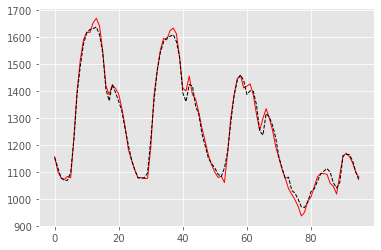

In [21]:
import matplotlib.pyplot as plt
plt.plot(y_test_unscaled, color="red", linewidth=1,label='Actual')
plt.plot(y_pred,'--', color="black", linewidth=1,label='Predicted')
plt.savefig('try.png', format='png', dpi=1080)
#plt.savefig('E:\\DataSets\\ShortTermLF\\NTDC\\NTDC_Final_Approch\\Model_Graph.pdf', format='pdf', dpi=1080)